This prediction is for  LCLId = MAC000002
* Using ARIMA
* Using MSTL

In [1]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import sys
sys.path.append("..")
from db.duckdb.duckdbhelper import DuckDBDatabaseHelper
db = DuckDBDatabaseHelper("../meters.db")

In [3]:
train = pd.read_csv("../model_data/train_day.csv")
test = pd.read_csv("../model_data/test_day.csv")

In [4]:
train.columns

Index(['day', 'energy_sum', 'temperatureMin', 'temperatureMax', 'uvIndex',
       'dewPoint', 'Type', 'month', 'LCLid', 'Type_Binary'],
      dtype='object')

In [5]:
len(train)

370

In [6]:
train.head()

,day,energy_sum,temperatureMin,temperatureMax,uvIndex,dewPoint,Type,month,LCLid,Type_Binary
0,2013-01-03,10.074,9.65,11.41,1.0,9.12,NaN,1,MAC000002,0
1,2013-01-06,10.293,6.91,8.61,1.0,7.00,NaN,1,MAC000002,0
2,2013-01-07,9.439,7.10,9.08,1.0,6.78,NaN,1,MAC000002,0
3,2013-01-11,10.979,0.89,5.70,1.0,1.68,NaN,1,MAC000002,0
4,2013-01-12,10.586,1.75,4.53,1.0,0.79,NaN,1,MAC000002,0


In [7]:
df = pd.DataFrame()
df["unique_id"] =["Energy"] *len(train)
df["ds"] = train["day"]
df["y"] = train["energy_sum"]
#Add exogenous regressors
# 'temperatureMin', 'temperatureMax', 'uvIndex',
# 'dewPoint', 'Type_Binary'

df['temperatureMin'] = train['temperatureMin']
df['temperatureMax'] = train['temperatureMax']
df['uvIndex'] = train['uvIndex']
df['dewPoint'] = train['dewPoint']
df['Type_Binary'] = train['Type_Binary']


In [8]:
X_df = pd.DataFrame()
X_df["unique_id"] = ["Energy"] *len(test)
X_df["ds"] = pd.to_datetime(test["day"])
X_df['temperatureMin'] = test['temperatureMin']
X_df['temperatureMax'] = test['temperatureMax']
X_df['uvIndex'] = test['uvIndex']
X_df['dewPoint'] = test['dewPoint']
X_df['Type_Binary'] = test['Type_Binary']

In [9]:
X_df[:6]

,unique_id,ds,temperatureMin,temperatureMax,uvIndex,dewPoint,Type_Binary
0,Energy,2014-01-01,6.59,11.34,NaN,6.78,1
1,Energy,2014-01-02,6.54,10.75,1.0,6.02,0
2,Energy,2014-01-03,7.01,10.49,1.0,5.08,0
3,Energy,2014-01-06,9.34,12.57,1.0,7.64,0
4,Energy,2014-01-07,8.98,11.38,1.0,6.63,0
5,Energy,2014-01-08,7.37,11.62,1.0,7.02,0


In [10]:
len(df)

370

In [11]:
df = df.dropna()

In [12]:
len(df)

365

In [13]:
df.head()

,unique_id,ds,y,temperatureMin,temperatureMax,uvIndex,dewPoint,Type_Binary
0,Energy,2013-01-03,10.074,9.65,11.41,1.0,9.12,0
1,Energy,2013-01-06,10.293,6.91,8.61,1.0,7.00,0
2,Energy,2013-01-07,9.439,7.10,9.08,1.0,6.78,0
3,Energy,2013-01-11,10.979,0.89,5.70,1.0,1.68,0
4,Energy,2013-01-12,10.586,1.75,4.53,1.0,0.79,0


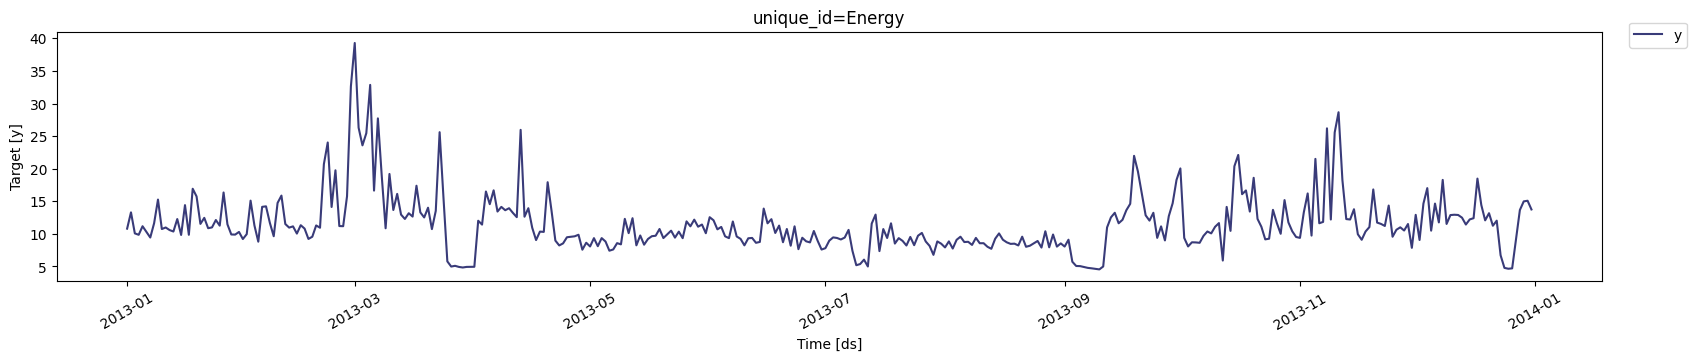

In [14]:
StatsForecast.plot(df)

In [15]:
sf = StatsForecast(
    models=[AutoARIMA()],
    freq='D'
)
sf.fit(df)

StatsForecast(models=[AutoARIMA])

In [16]:
horizon = 31
level = [95]

forecast_df = sf.forecast(df=df, h=horizon, X_df=X_df, level=level)
forecast_df.head()


,unique_id,ds,AutoARIMA,AutoARIMA-lo-95,AutoARIMA-hi-95
0,Energy,2014-01-01,NaN,NaN,NaN
1,Energy,2014-01-02,13.051928,5.691445,20.412410
2,Energy,2014-01-03,12.296550,4.584426,20.008675
3,Energy,2014-01-04,13.582147,5.566258,21.598036
4,Energy,2014-01-05,13.970739,5.892063,22.049416


### Verify the predictions

In [17]:
sql_query ="""

SELECT day,energy_sum,
LCLid
FROM  meters m 
WHERE date_part('year', day) = 2014
AND  date_part('month', day) = 1
AND LCLid = 'MAC000002'
"""

db.connect()
records = db.fetch_all(sql_query)
db.close_connection()

Connected to DuckDB database: ../meters.db
Fetched 31 rows.
Connection closed.


In [18]:
df_LCLid = pd.DataFrame(records)

In [19]:
df_LCLid.iloc[:,1][:4]

0    15.496
1    14.195
2    11.382
3    16.176
Name: 1, dtype: float64

In [20]:
forecast_df["actual"] = df_LCLid.iloc[:,1]

In [21]:
mae = abs(forecast_df["actual"]-forecast_df["AutoARIMA"]).mean()
print('The MAE is '+str(round(mae,2)))


The MAE is 3.05


In [22]:
from statsforecast import StatsForecast
from statsforecast.models import MSTL, AutoARIMA, SeasonalNaive
from statsforecast.utils import AirPassengers as ap


In [23]:
mstl = MSTL(
    season_length=[1], # seasonalities of the time series 
    trend_forecaster=AutoARIMA() # model used to forecast trend
)


In [24]:
sf = StatsForecast(
    models=[mstl], # model used to fit each time series 
    freq='D', # frequency of the data
)

In [25]:
df = df.drop_duplicates()

In [26]:
len(df)

365

In [27]:
df.head()

,unique_id,ds,y,temperatureMin,temperatureMax,uvIndex,dewPoint,Type_Binary
0,Energy,2013-01-03,10.074,9.65,11.41,1.0,9.12,0
1,Energy,2013-01-06,10.293,6.91,8.61,1.0,7.00,0
2,Energy,2013-01-07,9.439,7.10,9.08,1.0,6.78,0
3,Energy,2013-01-11,10.979,0.89,5.70,1.0,1.68,0
4,Energy,2013-01-12,10.586,1.75,4.53,1.0,0.79,0


In [28]:
forecast_df = sf.forecast(df=df, h=horizon, X_df=X_df, level=level)
forecast_df.head()

,unique_id,ds,MSTL,MSTL-lo-95,MSTL-hi-95
0,Energy,2014-01-01,NaN,NaN,NaN
1,Energy,2014-01-02,13.051928,5.691445,20.412410
2,Energy,2014-01-03,12.296550,4.584426,20.008675
3,Energy,2014-01-04,13.582147,5.566258,21.598036
4,Energy,2014-01-05,13.970739,5.892063,22.049416


In [29]:
forecast_df.head()

,unique_id,ds,MSTL,MSTL-lo-95,MSTL-hi-95
0,Energy,2014-01-01,NaN,NaN,NaN
1,Energy,2014-01-02,13.051928,5.691445,20.412410
2,Energy,2014-01-03,12.296550,4.584426,20.008675
3,Energy,2014-01-04,13.582147,5.566258,21.598036
4,Energy,2014-01-05,13.970739,5.892063,22.049416


In [30]:
forecast_df["actual"] = df_LCLid.iloc[:,1]

In [31]:
mae = abs(forecast_df["actual"]-forecast_df["MSTL"]).mean()
print('The MAE is '+str(round(mae,2)))

The MAE is 3.05
